In [1]:
from utils import *
from extract_feature_AE import *
from extract_feature_PCA import *

In [2]:
import numpy as np
np.random.seed(42)

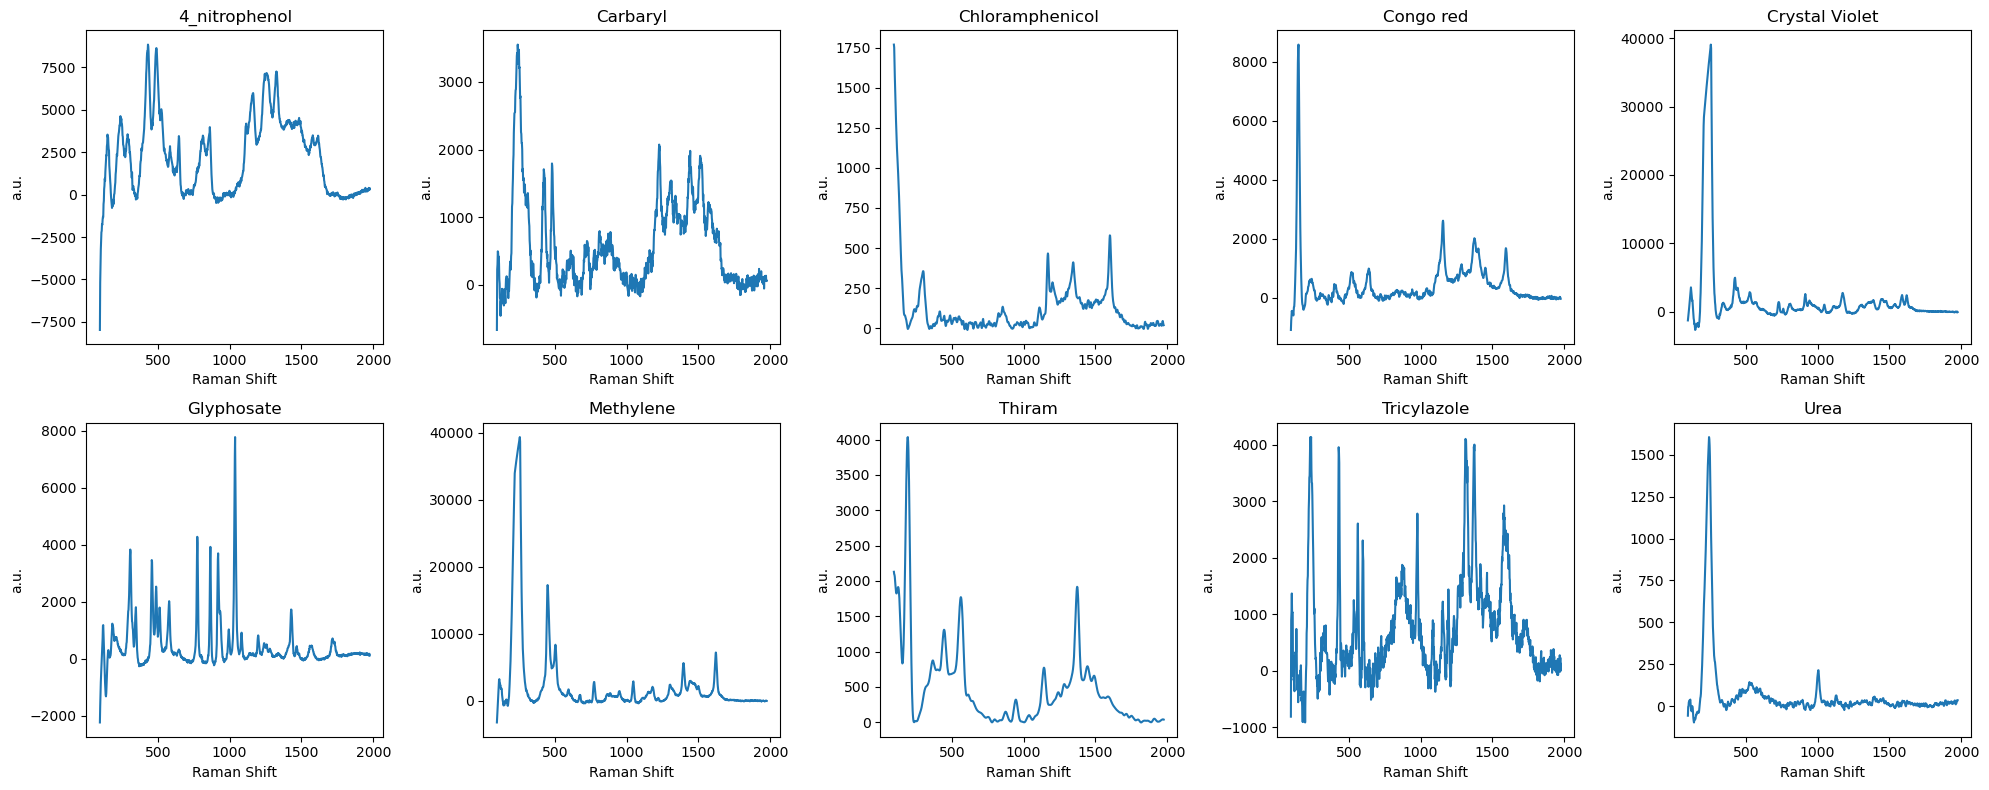

In [3]:
plot_data(paths, labels, file_names[0], 2, 5, figsize = (20, 8))

In [4]:
X, y = make_data(paths)
print(X.shape, y.shape)


(50, 2047) (50, 1)


In [5]:
X_min = X.min(axis=0, keepdims=True)
X_max = X.max(axis=0, keepdims=True)
X_mean = np.mean(X)
X_std = np.std(X)

In [6]:
# X= Norm(X, X_min, X_max, X_mean, X_std)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, stratify=y, shuffle= True, random_state= 42)

In [8]:
X_min = X_train.min(axis=0, keepdims=True)
X_max = X_train.max(axis=0, keepdims=True)
X_mean = np.mean(X_train)
X_std = np.std(X_train)

In [9]:
X_train = Norm(X_train, X_min, X_max, X_mean, X_std)
X_test  = Norm(X_test, X_min, X_max, X_mean, X_std)

In [10]:
y_test

array([[0.],
       [9.],
       [3.],
       [4.],
       [8.],
       [5.],
       [2.],
       [4.],
       [6.],
       [5.],
       [2.],
       [9.],
       [7.],
       [3.],
       [0.],
       [1.],
       [8.],
       [6.],
       [1.],
       [7.]])

In [11]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30, 2047) (30, 1) (20, 2047) (20, 1)


# Grid search

In [12]:
Grid_search_model(X_train,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}, score: 0.90
Time taken for Logistic Regression: 8.53 seconds

Best parameters for SVM: {'C': 1.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.80
Time taken for SVM: 2.02 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}, score: 0.90
Time taken for KNN: 7.34 seconds

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}, score: 0.57
Time taken for Decision Tree: 5.88 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}, score: 0.83
Time taken for Random Forest: 134.00 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.10
Time taken for Naive Bayes:

In [12]:
models = [LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear'),
          SVC(C = 1, degree = 2, gamma = 'scale', kernel = 'linear', shrinking = True,  probability=True),
          KNeighborsClassifier(algorithm = 'auto', metric = 'cosine', n_neighbors = 1, p = 1, weights = 'uniform'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 4, min_samples_split = 2, n_estimators = 100,  random_state = 42),
          BernoulliNB(alpha=0.1)]

In [13]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    file_name = f"./model/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/LogisticRegression.pkl' already saved
Model './model/SVC.pkl' already saved
Model './model/KNeighborsClassifier.pkl' already saved
Model './model/DecisionTreeClassifier.pkl' already saved
Model './model/RandomForestClassifier.pkl' already saved
Model './model/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]
Testing with SVC
Accuracy: 0.8500
Precision: 0.8400
Recall: 0.8500
F1-score: 0.8238
[3. 3. 3. 4. 8. 5. 2. 4. 6. 5. 2. 3. 7. 3. 0. 1. 8. 6. 1. 7.]
Testing with KNeighborsClassifier
Accuracy: 0.9500
Precision: 0.9667
Recall: 0.9500
F1-score: 0.9467
[3. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]
Testing with DecisionTreeClassifier
Accuracy: 0.3000
Precision: 0.3333
Recall: 0.3000
F1-score: 0.3067
[7. 7. 7. 1. 8. 4. 4. 5. 6. 4. 2. 7. 3. 6. 0. 1. 8. 2. 3. 6.]
Testing with RandomForestClassifier
Accuracy: 0.8500
Precision: 0.7833
Recall: 0.8500
F1-score: 0.8100
[1. 5. 3. 4. 8. 5. 2. 4. 6. 5. 2. 0. 7. 3. 0. 1. 8. 6. 1. 7.]
Testing with BernoulliNB
Accuracy: 0.4000
Precision: 0.3700
Recall: 0.4000
F1-score: 0.3333
[2. 2. 9. 2. 8. 5. 2. 6. 7. 5. 2. 2. 7. 2. 2. 7. 2. 2. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0.

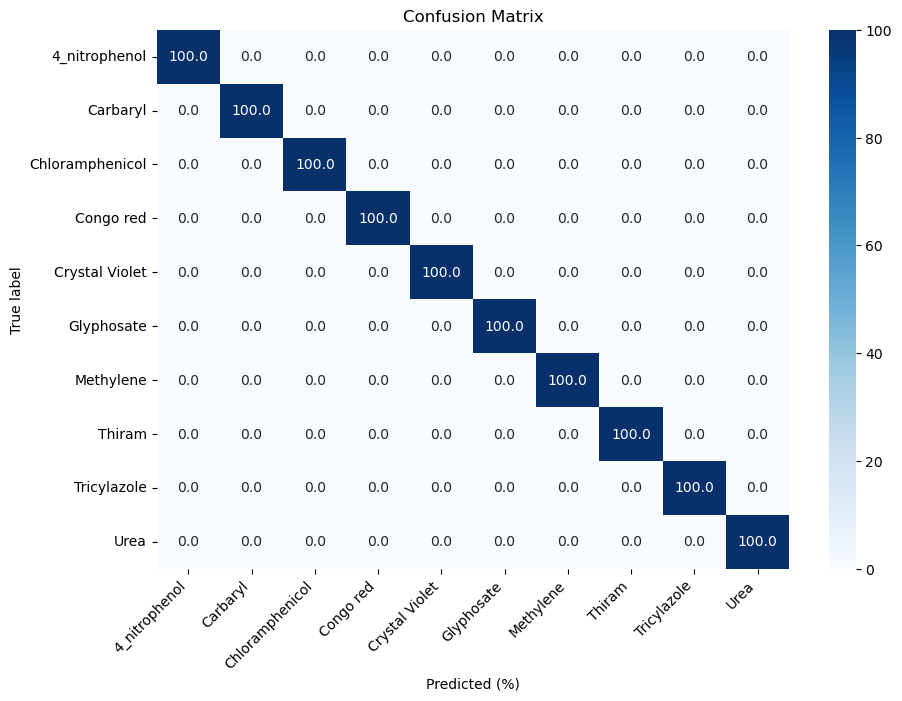

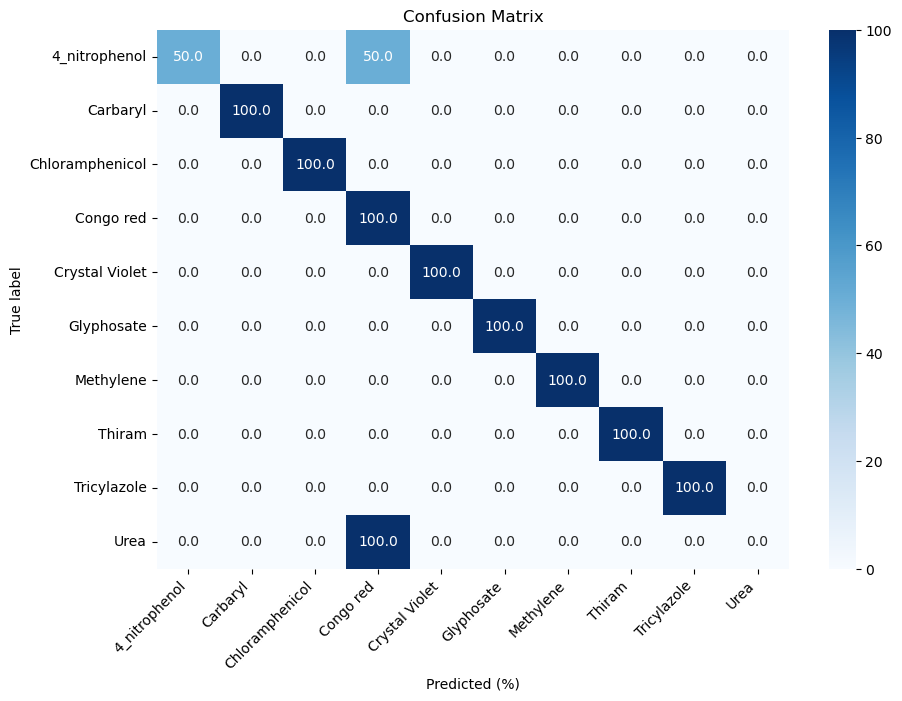

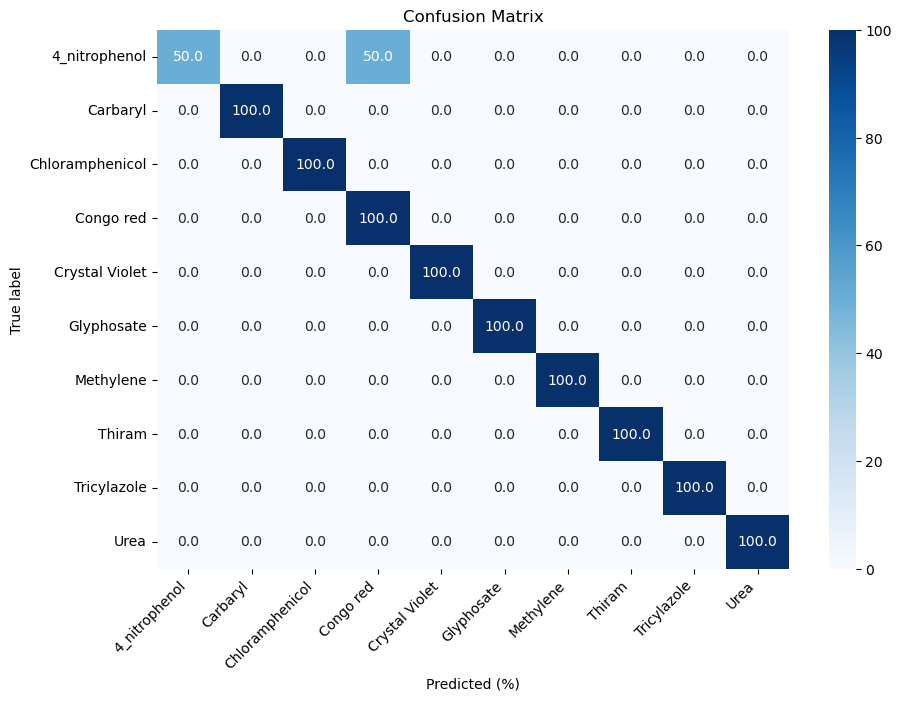

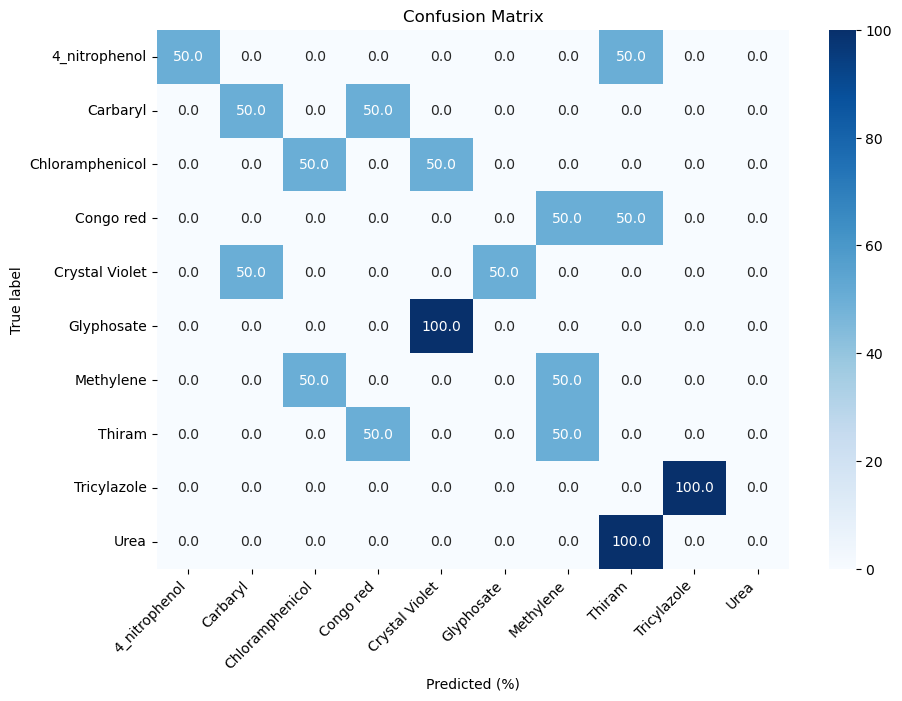

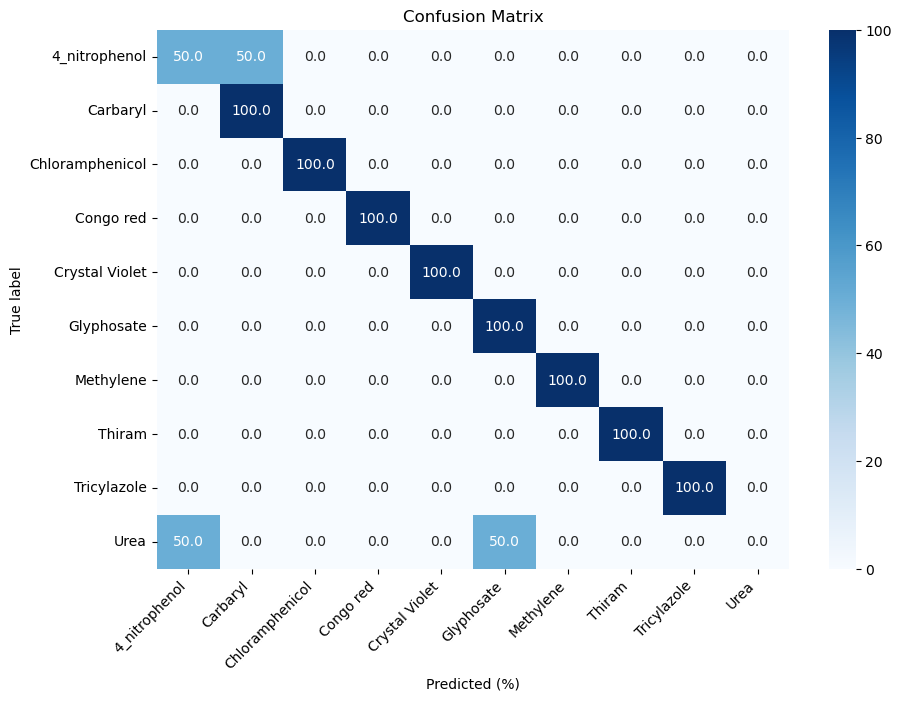

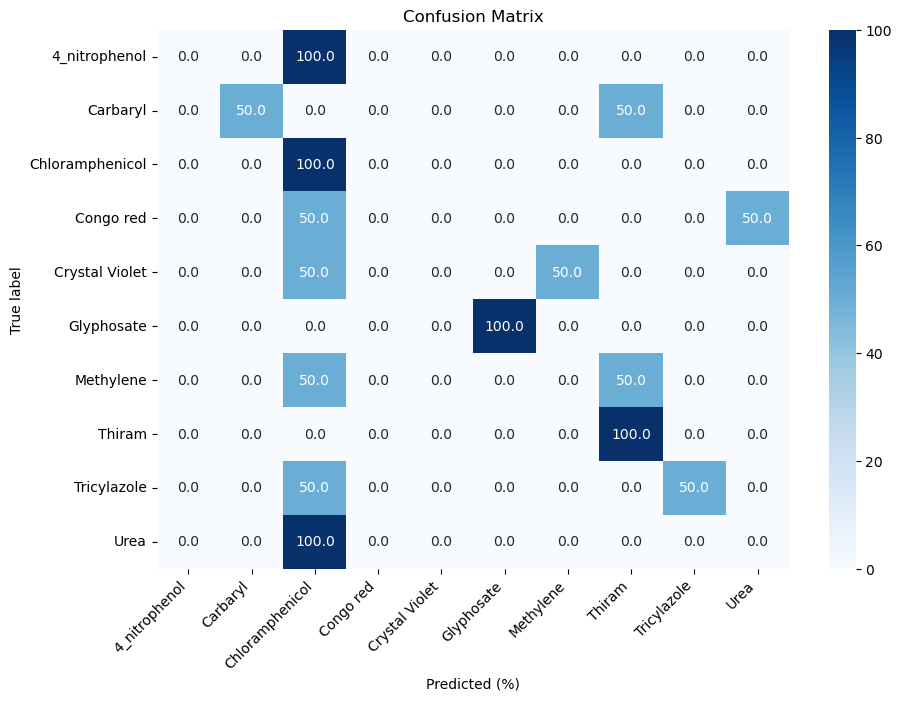

In [16]:
print(model_predict(X_test, y_test, models[0], X_min, X_max, X_mean, X_std)['Predict'])
print(y_test.T)

# Ensemble

In [65]:
from sklearn.ensemble import VotingClassifier

ensemble_clf = VotingClassifier(
    estimators=[
        ('logistic', models[0]),
        ('svc', models[1]),
        ('knn', models[2]),
        ('random_forest', models[4]),
    ],
    voting='soft'
)
ensemble_clf.fit(X_train, y_train.ravel())


VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=10, solver='liblinear')),
                             ('svc',
                              SVC(C=1, degree=2, kernel='linear',
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(metric='cosine',
                                                   n_neighbors=1, p=1)),
                             ('random_forest',
                              RandomForestClassifier(max_depth=2,
                                                     min_samples_leaf=4,
                                                     random_state=42))],
                 voting='soft')

Testing with VotingClassifier
Accuracy: 0.9500
Precision: 0.9667
Recall: 0.9500
F1-score: 0.9467
[3. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


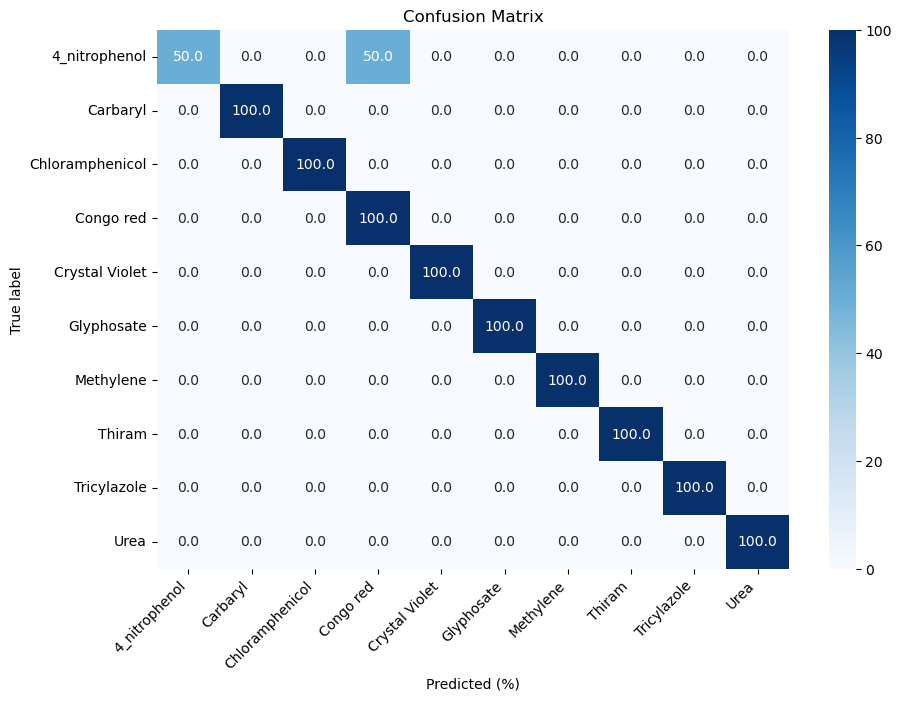

In [59]:
print(model_predict(X_test, y_test, ensemble_clf, X_min, X_max, X_mean, X_std)['Predict'])
print(y_test.T)

In [34]:
proba = ensemble_clf.predict_proba(X_test)
proba[0]


array([0.08652339, 0.04711939, 0.22889702, 0.27782245, 0.02301383,
       0.02410873, 0.02592277, 0.20158765, 0.0252463 , 0.05975846])

# Ensemble + Boosting

In [66]:
from sklearn.ensemble import AdaBoostClassifier


ensemble_clf = VotingClassifier(
    estimators=[
        ('logistic', models[0]),
        ('svc', models[1]),
        ('random_forest', models[4]),
    ],
    voting='soft'
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ensemble_clf.fit(X_train, y_train)

boosting_clf = AdaBoostClassifier(
    estimator=ensemble_clf,
    n_estimators=10,
    learning_rate=1.0
)
boosting_clf.fit(X_train, y_train.ravel())


AdaBoostClassifier(estimator=VotingClassifier(estimators=[('logistic',
                                                           LogisticRegression(C=10,
                                                                              solver='liblinear')),
                                                          ('svc',
                                                           SVC(C=1, degree=2,
                                                               kernel='linear',
                                                               probability=True)),
                                                          ('random_forest',
                                                           RandomForestClassifier(max_depth=2,
                                                                                  min_samples_leaf=4,
                                                                                  random_state=42))],
                                              voting='soft'),
                   n_estimators=10)

Testing with AdaBoostClassifier
Accuracy: 0.9500
Precision: 0.9667
Recall: 0.9500
F1-score: 0.9467
[0. 0. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


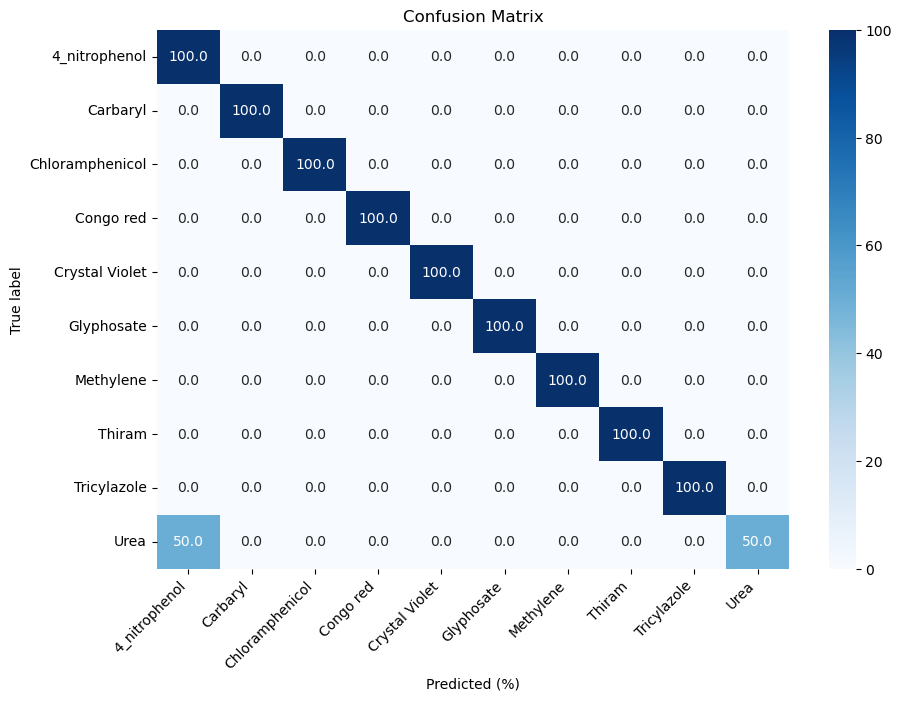

In [63]:
print(model_predict(X_test, y_test, boosting_clf, X_min, X_max, X_mean, X_std)['Predict'])
print(y_test.T)

# Testing

In [33]:
model_predict(X_test, y_test, models[0], X_min, X_max, X_mean, X_std, path = 'Tricyclazole So sanh.txt')['Class']

Testing with LogisticRegression


['Tricylazole']

# Feature extraction PCA and training

In [35]:
U = U_for_pca(X_train, X_mean, n_components = 3)
X_train_PCA = extract_PCA(X_train, X_mean, n_components=3)
# X_test_PCA = pca(X_test, X_mean, U)
X_test_PCA = extract_PCA(X_test, X_mean, n_components=3)

In [36]:
Grid_search_model(X_train_PCA,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.67
Time taken for Logistic Regression: 0.29 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.73
Time taken for SVM: 0.50 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}, score: 0.60
Time taken for KNN: 3.20 seconds

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}, score: 0.60
Time taken for Decision Tree: 0.90 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}, score: 0.67
Time taken for Random Forest: 101.12 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.13
Time taken for Naive Bayes:

In [48]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'gini', max_depth= 8, min_samples_leaf= 2, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50,  random_state = 42),
          BernoulliNB(alpha=0.1)]

In [49]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_PCA, y_train)
    file_name = f"./model/PCA/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/PCA/LogisticRegression.pkl' already saved
Model './model/PCA/SVC.pkl' already saved
Model './model/PCA/KNeighborsClassifier.pkl' already saved
Model './model/PCA/DecisionTreeClassifier.pkl' already saved
Model './model/PCA/RandomForestClassifier.pkl' already saved
Model './model/PCA/BernoulliNB.pkl' already saved


Testing with SVC
Accuracy: 0.0500
Precision: 0.0500
Recall: 0.0500
F1-score: 0.0500
[5. 5. 5. 1. 5. 3. 4. 8. 1. 4. 4. 5. 2. 4. 0. 0. 5. 8. 2. 4.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


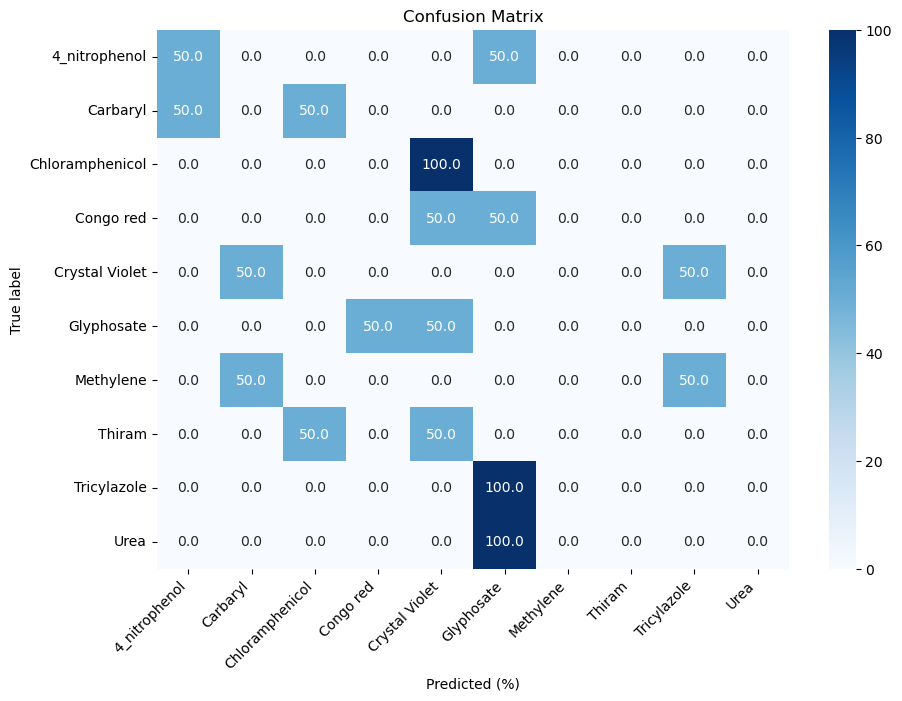

In [52]:
print(model_predict(X_test_PCA, y_test, models[1], X_min, X_max, X_mean, X_std)['Predict'])
print(y_test.T)

# Feature extraction AutoEncoder and training

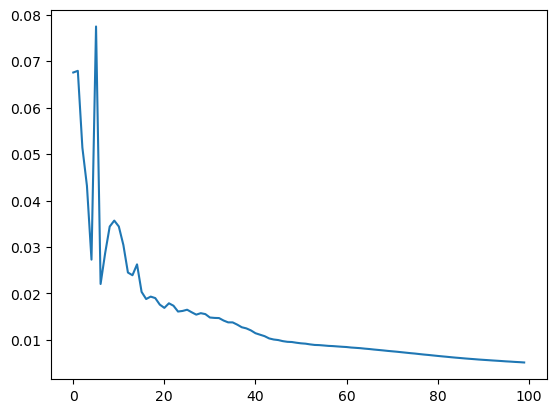

In [107]:
model = modelAE(X_train, out_features = 10, num_epochs = 100, learning_rate = 0.01)

In [108]:
X_train_AE = extractAE(model, X_train)
X_test_AE = extractAE(model, X_test)

In [109]:
Grid_search_model(X_train_AE,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.27
Time taken for Logistic Regression: 0.25 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.20
Time taken for SVM: 0.92 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'correlation', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}, score: 0.50
Time taken for KNN: 6.29 seconds

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}, score: 0.43
Time taken for Decision Tree: 1.74 seconds

Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}, score: 0.47
Time taken for Random Forest: 194.61 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.17
Time taken for Naive B

In [110]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100,  random_state = 42),
          BernoulliNB(alpha=0.01)]

In [111]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_PCA, y_train)
    file_name = f"./model/AutoEndcoder/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)

NameError: name 'X_train_PCA' is not defined

In [ ]:
print(model_predict(X_train_AE, y_train, X_test_AE, y_test, models[0], X_min, X_max, X_mean, X_std)['Predict'])
print(y_test.T)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30)  

X_tsne = tsne.fit_transform(X)


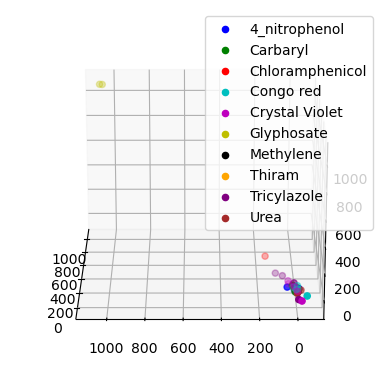

In [ ]:
visualize(X,y, option = "3d",eval = 20, azim = 180, legend = True)